# Desafio 1 - Maratona Behind the Code 2021
## Objetivo
O desafio consiste em criar um modelo de inteligência artificial capaz de realizar uma análise de risco para predizer se um empréstimo a um cliente deve ser feito ou não. Para isso, espera-se a utilização de um modelo de Machine Learning capaz de realizar uma classificação. O modelo pode ser desenvolvido na plataforma Watson Studio, e deve ser publicado em uma instância Watson Machine Learning. O modelo deverá ser treinado com os conjuntos de dados disponibilizado nesse repositório, contendo dados de clientes de bancos, como dados demográficos, sobre suas contas e sobre o empréstimo que querem realizar.

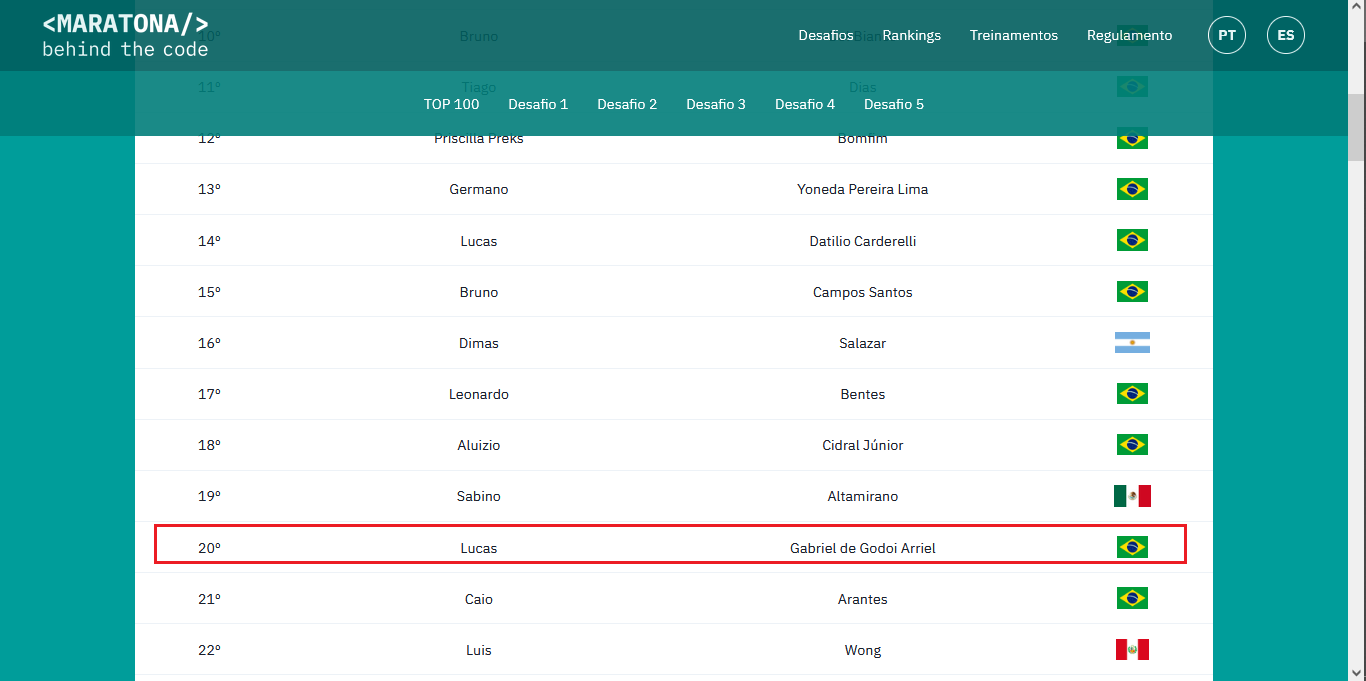

In [7]:
from PIL import Image
image = Image.open("Ranking20.png")
image

In [103]:
!python -m pip uninstall scikit-learn --yes #Desinstalar versão antiga

Found existing installation: scikit-learn 0.23.0
Uninstalling scikit-learn-0.23.0:
  Successfully uninstalled scikit-learn-0.23.0


In [ ]:
!pip install scikit-learn #Instalar versão mais recente

In [1]:
from sklearn import __version__ as sv
sv

'1.0.1'

In [ ]:
#Import das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier


# Ler os dataframes para treino e teste

In [3]:
dfLoans = pd.read_csv('data_asset\LOANS.csv')

In [4]:
dfDemo = pd.read_csv('data_asset\DEMOGRAPHICS.csv')

In [5]:
dfAcc = pd.read_csv('data_asset\ACCOUNTS.csv')

In [6]:
teste = pd.merge(dfLoans, dfAcc, on='ID', how='outer')
teste = pd.merge(teste, dfDemo, on='ID', how='outer')
df = teste

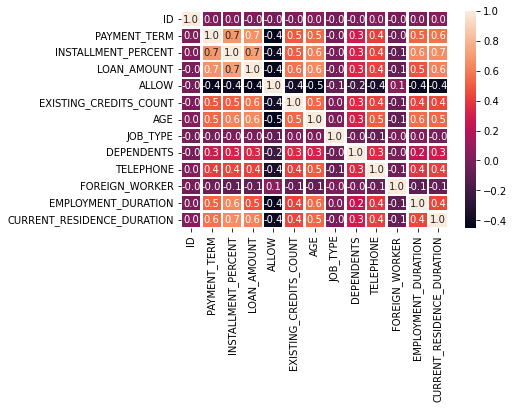

In [7]:
#utilizei para decidir quais colunas eram menos impactantes
sns.heatmap(df.corr(),linewidths=1.5, fmt=".1f", annot=True)

In [8]:
df

,ID,PAYMENT_TERM,INSTALLMENT_PLANS,INSTALLMENT_PERCENT,LOAN_PURPOSE,LOAN_AMOUNT,OTHERS_ON_LOAN,ALLOW,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT,SEX,AGE,JOB_TYPE,DEPENDENTS,TELEPHONE,FOREIGN_WORKER,EMPLOYMENT_DURATION,PROPERTY,HOUSING,CURRENT_RESIDENCE_DURATION
0,610339,713.0,STORES,3.0,CAR_USED,3103.0,NONE,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,109167,341.0,STORES,1.0,CAR_NEW,716.0,NONE,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,823322,868.0,NONE,4.0,APPLIANCES,4333.0,NONE,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,322224,310.0,STORES,2.0,FURNITURE,250.0,NONE,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,912693,620.0,NONE,2.0,CAR_USED,2454.0,NONE,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,636739,450.0,BANK,3.0,CAR_NEW,3007.0,CO-APPLICANT,0,163.82,CREDITS_PAID_TO_DATE,472.11,1.0,F,41.0,0.0,1.0,0.0,1.0,7.0,CAR_OTHER,OWN,3.0
3995,919733,510.0,NONE,4.0,VACATION,4191.0,GUARANTOR,1,14324.23,PRIOR_PAYMENTS_DELAYED,18652.44,1.0,M,46.0,3.0,1.0,1.0,1.0,11.0,SAVINGS_INSURANCE,OWN,3.0
3996,115839,124.0,STORES,1.0,FURNITURE,250.0,NONE,1,130.13,PRIOR_PAYMENTS_DELAYED,726.78,2.0,M,28.0,3.0,1.0,1.0,1.0,7.0,CAR_OTHER,RENT,1.0
3997,1128684,961.0,BANK,3.0,BUSINESS,5172.0,NONE,1,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,1.0,M,46.0,0.0,1.0,0.0,1.0,7.0,CAR_OTHER,RENT,3.0


In [9]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['CHECKING_BALANCE'] = data['CHECKING_BALANCE'].replace('NO_CHECKING', np.nan)
        data['EXISTING_SAVINGS'] = data['EXISTING_SAVINGS'].replace('UNKNOWN', np.nan)
        return data.drop(labels=self.columns, axis='columns')

In [10]:
X = df.drop('ALLOW', axis=1, inplace=False)
y = df.ALLOW

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# Criação do Pipeline usando RandomForest

In [12]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

Cat_features = ['SEX', 'HOUSING', 'PROPERTY', 'CREDIT_HISTORY', 
            'INSTALLMENT_PLANS', 'LOAN_PURPOSE', 'OTHERS_ON_LOAN']
unwanted_columns = ['ID', 'TELEPHONE', 'FOREIGN_WORKER', 'DEPENDENTS', 'JOB_TYPE']
Num_features = list((set(X.columns) - set(unwanted_columns) - set(Cat_features)))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', fill_value= round(X.mean()))),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, Num_features),
        ('cat', categorical_transformer, Cat_features)
    ]
)

dropCol = DropColumns(unwanted_columns)
pip_2 = Pipeline(steps=[
    ('drop_columns', dropCol),
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=11, min_samples_leaf=1))
])

In [13]:
pip_2.fit(X_train,y_train)
pip_2.score(X_test, y_test)

0.795

In [14]:
#Verificar o score inicial
Score = cross_val_score(pip_2, X_train, y_train, cv=10, scoring='f1')

In [15]:
Score.mean()

0.8593911578982883

In [17]:
#Fui realizando várias vezes o GridSearch 
#e peguei uma média com diferentes cv
#por isso pode estar diferente dos parâmetros
grid_param =[
    {
     "clf__n_estimators": [120, 150, 200, 250],
     "clf__max_depth": [3, 5, 11, None],
     'clf__max_features': ['auto', 'sqrt'],
     "clf__min_samples_leaf": [1, 2, 3, 5]
    }
]
gridsearch = GridSearchCV(pip_2, param_grid=grid_param, scoring='roc_auc', cv=3)
best_model = gridsearch.fit(X_train,y_train)

In [20]:
best_model.best_params_

{'clf__max_depth': None,
 'clf__max_features': 'auto',
 'clf__min_samples_leaf': 5,
 'clf__n_estimators': 120}

# Comparar os resultados e selecionar o melhor

In [18]:
Score = cross_val_score(best_model.best_estimator_, X_train, y_train, cv=10, scoring='f1')
print(Score.mean())

0.8594679099191909


In [21]:
y_pred_test = pip_2.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.54      0.64       265
           1       0.80      0.92      0.86       535

    accuracy                           0.80       800
   macro avg       0.79      0.73      0.75       800
weighted avg       0.79      0.80      0.78       800



In [22]:
y_pred_test = best_model.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.73      0.54      0.62       265
           1       0.80      0.90      0.85       535

    accuracy                           0.78       800
   macro avg       0.76      0.72      0.73       800
weighted avg       0.77      0.78      0.77       800



In [ ]:
# Na ultima ficou pior, aí continuei com o resultado anterior
# pip_2 = best_model.best_estimator_
# Score = cross_val_score(pip_2, X_train, y_train, cv=10, scoring='f1')
# print(Score.mean())

# Formulação da resposta

In [25]:
Ans = pd.read_csv('ANSWERS.csv')
AnsToPred = Ans.drop('ALLOW', axis=1)

In [26]:
AnsPred = pip_2.predict(AnsToPred)
AnsPred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,

In [27]:
Ans['ALLOW'] = AnsPred

In [28]:
Ans.to_csv('./ANSWER.csv', index=False)